<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px\" align="left">

## Purity Randomized Benchmarking


- Last Updated: June 24, 2019
- Requires: qiskit-terra 0.8, qiskit-ignis 0.1.1, qiskit-aer 0.2

## Introduction

**Purity Randomized Benchmarking** is a variant of the Randomized Benchmarking (RB) method, which quantifies how *coherent* the errors are. The protocol executes the RB sequneces containing of Clifford gates, and then calculates the *purity* $Tr(\rho^2)$, and fits the purity result to an exponentially decaying curve.

This notebook gives an example for how to use the ``ignis.verification.randomized_benchmarking`` module in order to perform purity RB.

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

#Import Qiskit classes classes
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, coherent_unitary_error

## Select the Parameters of the Purity RB Run

First, wee need to choose the regular RB parameters:

- **nseeds**: The number of seeds. For each seed there you will get a separate list of output circuits.
- **length_vector**: The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern**: A list of the form [[i],[j],[k],...] or [[i,j],[k,l],...], etc. which will make simultaneous RB sequences. All the patterns should have the same dimetion, namely only 1-qubit sequences Qk or only 2-qubit sequences Qi,Qj, etc. The number of qubits is the sum of the entries.
- **length_multiplier = None**: No length_multiplier for purity RB.
- **seed_offset**: What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs**: If true adds a barrier across all qubits in rb_pattern after each set of cliffords.

As well as another parameter for purity RB:

- **is_purity = True**

In this example we have 4 qubits Q0,Q1,Q2,Q3. We are running 2Q RB (on qubits Q0,Q1 and on qubits Q2,Q3) simultaneously. 

In [2]:
# Example of 2-qubits Purity RB
#Number of qubits
nQ = 4
#Number of seeds (random sequences)
nseeds = 3
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)
#2Q RB on Q0,Q2 and 1Q RB on Q1
rb_pattern = [[0,1],[2,3]]

## Generate Purity RB sequences

We generate purity RB sequences. We start with a small example (so it doesn't take too long to run).

In order to generate the purity RB sequences **rb_purity_circs**, which is a list of lists of lists of quantum circuits, we run the function rb.randomized_benchmarking_seq.

This function returns:

- **rb_purity_circs**: A list of lists of lists of circuits for the purity rb sequences (separate list for each of the $3^n$ options and for each seed).
- **xdata**: The Clifford lengths (with multiplier if applicable).
- **rb_opts_dict**: Option dictionary back out with default options appended.

As well as:

- **npurity**: the number of purity rb circuits (per seed) which equals to $3^n$, where $n$ is the dimension, e.g npurity=3 for 1-qubit RB, npurity=9 for 2-qubit RB.

In order to generate each of the $3^n$ circuits, we need to do (per each of the $n$ qubits) either:
- nothing (Pauli-$Z$), or
- $\pi/2$-rotation around $x$ (Pauli-$X$), or
- $\pi/2$-rotation around $y$ (Pauli-$Y$),

and then measure the result.

In [3]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['is_purity'] = True
rb_purity_circs, xdata, npurity = rb.randomized_benchmarking_seq(**rb_opts)
print (npurity)

9


To illustrate, we print the circuit names for purity RB.

In [4]:
for i in range(len(rb_purity_circs)):
    for j in range(len(rb_purity_circs[i])):
        for k in range(len(rb_purity_circs[i][j])):
            print (rb_purity_circs[i][j][k].name)

rb_purity_ZZ_length_0_seed_0
rb_purity_ZZ_length_1_seed_0
rb_purity_ZZ_length_2_seed_0
rb_purity_ZZ_length_3_seed_0
rb_purity_ZZ_length_4_seed_0
rb_purity_ZZ_length_5_seed_0
rb_purity_ZZ_length_6_seed_0
rb_purity_ZZ_length_7_seed_0
rb_purity_ZZ_length_8_seed_0
rb_purity_ZZ_length_9_seed_0
rb_purity_XZ_length_0_seed_0
rb_purity_XZ_length_1_seed_0
rb_purity_XZ_length_2_seed_0
rb_purity_XZ_length_3_seed_0
rb_purity_XZ_length_4_seed_0
rb_purity_XZ_length_5_seed_0
rb_purity_XZ_length_6_seed_0
rb_purity_XZ_length_7_seed_0
rb_purity_XZ_length_8_seed_0
rb_purity_XZ_length_9_seed_0
rb_purity_YZ_length_0_seed_0
rb_purity_YZ_length_1_seed_0
rb_purity_YZ_length_2_seed_0
rb_purity_YZ_length_3_seed_0
rb_purity_YZ_length_4_seed_0
rb_purity_YZ_length_5_seed_0
rb_purity_YZ_length_6_seed_0
rb_purity_YZ_length_7_seed_0
rb_purity_YZ_length_8_seed_0
rb_purity_YZ_length_9_seed_0
rb_purity_ZX_length_0_seed_0
rb_purity_ZX_length_1_seed_0
rb_purity_ZX_length_2_seed_0
rb_purity_ZX_length_3_seed_0
rb_purity_ZX_l

As an example, we print the circuit corresponding to the first RB sequences, for each of the $3^n$ parameters.

In [5]:
for i in range(npurity):
    print ("circ no. ", i)
    print (rb_purity_circs[0][i][0])

circ no.  0
          ┌───┐ ┌───┐┌───┐       ┌───┐ ┌───┐        ░   ┌───┐      ┌───┐       »
qr_0: |0>─┤ H ├─┤ H ├┤ S ├───■───┤ X ├─┤ Y ├────────░───┤ Y ├──────┤ X ├───■───»
          └───┘ └───┘└───┘ ┌─┴─┐ └─┬─┘┌┴───┴┐┌───┐  ░   ├───┤ ┌───┐└─┬─┘ ┌─┴─┐ »
qr_1: |0>──────────────────┤ X ├───■──┤ Sdg ├┤ H ├──░───┤ H ├─┤ S ├──■───┤ X ├─»
         ┌─────┐┌───┐      ├───┤ ┌───┐└┬───┬┘└─░─┘┌───┐┌┴───┴┐├───┤      ├───┤ »
qr_2: |0>┤ Sdg ├┤ H ├──■───┤ H ├─┤ S ├─┤ Y ├───░──┤ Y ├┤ Sdg ├┤ H ├──■───┤ H ├─»
         └┬───┬┘├───┤┌─┴─┐┌┴───┴┐├───┤ └───┘   ░  ├───┤└┬───┬┘└───┘┌─┴─┐┌┴───┴┐»
qr_3: |0>─┤ H ├─┤ S ├┤ X ├┤ Sdg ├┤ H ├─────────░──┤ H ├─┤ S ├──────┤ X ├┤ Sdg ├»
          └───┘ └───┘└───┘└─────┘└───┘         ░  └───┘ └───┘      └───┘└─────┘»
 cr_0: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 cr_1: 0 ══════════════════════════════════════════════════════════════════════»
                

          ┌───┐ ┌───┐┌───┐       ┌───┐ ┌───┐        ░   ┌───┐      ┌───┐       »
qr_0: |0>─┤ H ├─┤ H ├┤ S ├───■───┤ X ├─┤ Y ├────────░───┤ Y ├──────┤ X ├───■───»
          └───┘ └───┘└───┘ ┌─┴─┐ └─┬─┘┌┴───┴┐┌───┐  ░   ├───┤ ┌───┐└─┬─┘ ┌─┴─┐ »
qr_1: |0>──────────────────┤ X ├───■──┤ Sdg ├┤ H ├──░───┤ H ├─┤ S ├──■───┤ X ├─»
         ┌─────┐┌───┐      ├───┤ ┌───┐└┬───┬┘└─░─┘┌───┐┌┴───┴┐├───┤      ├───┤ »
qr_2: |0>┤ Sdg ├┤ H ├──■───┤ H ├─┤ S ├─┤ Y ├───░──┤ Y ├┤ Sdg ├┤ H ├──■───┤ H ├─»
         └┬───┬┘├───┤┌─┴─┐┌┴───┴┐├───┤ └───┘   ░  ├───┤└┬───┬┘└───┘┌─┴─┐┌┴───┴┐»
qr_3: |0>─┤ H ├─┤ S ├┤ X ├┤ Sdg ├┤ H ├─────────░──┤ H ├─┤ S ├──────┤ X ├┤ Sdg ├»
          └───┘ └───┘└───┘└─────┘└───┘         ░  └───┘ └───┘      └───┘└─────┘»
 cr_0: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 cr_1: 0 ══════════════════════════════════════════════════════════════════════»
                            

## Define a non-coherent noise model

We define a non-coherent noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT and U gates.

In [6]:
noise_model = NoiseModel()
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

We can execute the purity RB sequences either using Qiskit Aer Simulator (with some noise model) or using IBMQ provider, and obtain a list of results result_list.

In [7]:
#Execute purity RB circuits 
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 200
purity_result_list = []
import time
for rb_seed in range(len(rb_purity_circs)):
    for d in range(npurity):
        print('Executing seed %d purity %d length %d'%(rb_seed, d, len(nCliffs)))
        new_circ = rb_purity_circs[rb_seed][d]
        job = qiskit.execute(new_circ, backend=backend, noise_model=noise_model, shots=shots, basis_gates=['u1','u2','u3','cx'])
        purity_result_list.append(job.result())
print("Finished Simulating Purity RB Circuits")

Executing seed 0 purity 0 length 10
Executing seed 0 purity 1 length 10
Executing seed 0 purity 2 length 10
Executing seed 0 purity 3 length 10
Executing seed 0 purity 4 length 10
Executing seed 0 purity 5 length 10
Executing seed 0 purity 6 length 10
Executing seed 0 purity 7 length 10
Executing seed 0 purity 8 length 10
Executing seed 1 purity 0 length 10
Executing seed 1 purity 1 length 10
Executing seed 1 purity 2 length 10
Executing seed 1 purity 3 length 10
Executing seed 1 purity 4 length 10
Executing seed 1 purity 5 length 10
Executing seed 1 purity 6 length 10
Executing seed 1 purity 7 length 10
Executing seed 1 purity 8 length 10
Executing seed 2 purity 0 length 10
Executing seed 2 purity 1 length 10
Executing seed 2 purity 2 length 10
Executing seed 2 purity 3 length 10
Executing seed 2 purity 4 length 10
Executing seed 2 purity 5 length 10
Executing seed 2 purity 6 length 10
Executing seed 2 purity 7 length 10
Executing seed 2 purity 8 length 10
Finished Simulating Purity R

## Fit the results

Calculate the *purity* $Tr(\rho^2)$ as the sum $\sum_k \langle P_k \rangle ^2/2^n$, and fit the purity result into an exponentially decaying function to obtain $\alpha$.

In [8]:
rbfit_purity = rb.PurityRBFitter(purity_result_list, npurity, xdata, rb_opts['rb_pattern'])

Print the fit result (seperately for each pattern)

In [9]:
print ("fit:", rbfit_purity.fit)

fit: [{'params': array([0.75163487, 0.98554775, 0.26283338]), 'params_err': array([0.01433558, 0.00047206, 0.00073454]), 'epc': 0.021521729008479734, 'epc_err': 0.0007237241929079784, 'pepc': 0.010839189862151682, 'pepc_err': 0.0003592377185900463}, {'params': array([0.74679215, 0.9835602 , 0.26501484]), 'params_err': array([0.00880608, 0.00045893, 0.00269894]), 'epc': 0.024457001621703306, 'epc_err': 0.0007057333217703058, 'pepc': 0.012329850960659722, 'pepc_err': 0.00034995411195546327}]


## Plot the results and the fit

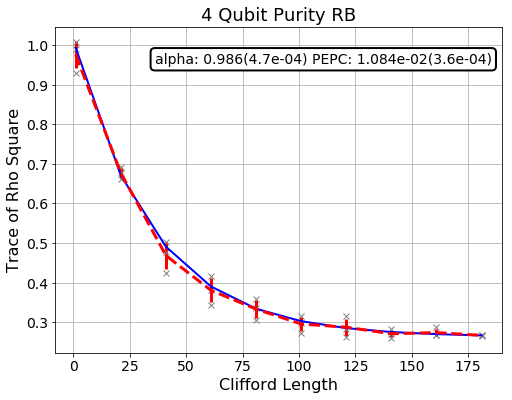

In [10]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rbfit_purity.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit Purity RB'%(nQ), fontsize=18)

plt.show()

## Standard RB results

For comparison, we also print the standard RB fit results

In [11]:
standard_result_list = []
count = 0
for rb_seed in range(len(rb_purity_circs)):
    for d in range(npurity):
        if d==0:
            standard_result_list.append(purity_result_list[count])
        count += 1

In [12]:
rbfit_standard = rb.RBFitter(standard_result_list, xdata, rb_opts['rb_pattern'])

In [13]:
print (rbfit_standard.fit)

[{'params': array([0.76355717, 0.98581042, 0.23369482]), 'params_err': array([0.01063052, 0.00059587, 0.01176143]), 'epc': 0.010642188498914434, 'epc_err': 0.00045333806943769216}, {'params': array([0.78257633, 0.98574059, 0.21856392]), 'params_err': array([0.00468259, 0.00040281, 0.00484034]), 'epc': 0.010694560974121053, 'epc_err': 0.00030647543191107896}]


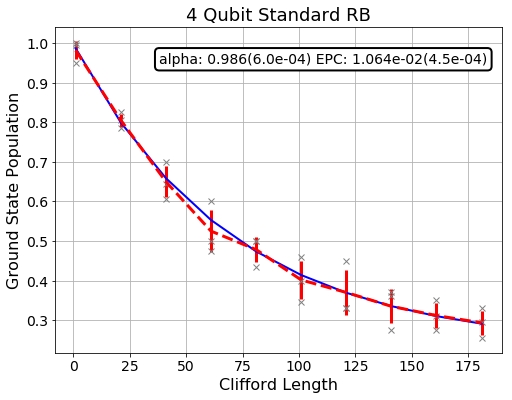

In [14]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rbfit_standard.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit Standard RB'%(nQ), fontsize=18)

plt.show()

## Define a coherent noise model

We define a coherent noise model for the simulator. 

In [15]:
err_unitary = np.zeros([2, 2], dtype=complex)
angle_err = 0.1
for i in range(2):
    err_unitary[i, i] = np.cos(angle_err)
    err_unitary[i, (i+1) % 2] = np.sin(angle_err)
err_unitary[0, 1] *= -1.0

error = coherent_unitary_error(err_unitary)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error, 'u3')

In [16]:
#Execute purity RB circuits 
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 200
coherent_purity_result_list = []
import time
for rb_seed in range(len(rb_purity_circs)):
    for d in range(npurity):
        print('Executing seed %d purity %d length %d'%(rb_seed, d, len(nCliffs)))
        new_circ = rb_purity_circs[rb_seed][d]
        job = qiskit.execute(new_circ, backend=backend, shots=shots, noise_model=noise_model, basis_gates=['u1','u2','u3','cx'])
        coherent_purity_result_list.append(job.result())
print("Finished Simulating Purity RB Circuits")

Executing seed 0 purity 0 length 10
Executing seed 0 purity 1 length 10
Executing seed 0 purity 2 length 10
Executing seed 0 purity 3 length 10
Executing seed 0 purity 4 length 10
Executing seed 0 purity 5 length 10
Executing seed 0 purity 6 length 10
Executing seed 0 purity 7 length 10
Executing seed 0 purity 8 length 10
Executing seed 1 purity 0 length 10
Executing seed 1 purity 1 length 10
Executing seed 1 purity 2 length 10
Executing seed 1 purity 3 length 10
Executing seed 1 purity 4 length 10
Executing seed 1 purity 5 length 10
Executing seed 1 purity 6 length 10
Executing seed 1 purity 7 length 10
Executing seed 1 purity 8 length 10
Executing seed 2 purity 0 length 10
Executing seed 2 purity 1 length 10
Executing seed 2 purity 2 length 10
Executing seed 2 purity 3 length 10
Executing seed 2 purity 4 length 10
Executing seed 2 purity 5 length 10
Executing seed 2 purity 6 length 10
Executing seed 2 purity 7 length 10
Executing seed 2 purity 8 length 10
Finished Simulating Purity R

In [17]:
rbfit_purity = rb.PurityRBFitter(coherent_purity_result_list, npurity, xdata, rb_opts['rb_pattern'])

Print the fit result (seperately for each pattern)

In [18]:
print ("fit:", rbfit_purity.fit)

fit: [{'params': array([ 2.        ,  0.99994085, -0.99123082]), 'params_err': array([7.02368933e+02, 2.10013074e-02, 7.02396646e+02]), 'epc': 8.872549519881034e-05, 'epc_err': 0.03150475637673385, 'pepc': 4.436405971261492e-05, 'pepc_err': 0.015751912288512707}, {'params': array([0.29481181, 1.        , 0.7239019 ]), 'params_err': array([0.00505217, 0.00035111, 0.00505217]), 'epc': 8.326672684688674e-17, 'epc_err': 0.0005266649630270721, 'pepc': 8.326672684688674e-17, 'pepc_err': 0.0002633324815135361}]


## Plot the results and the fit

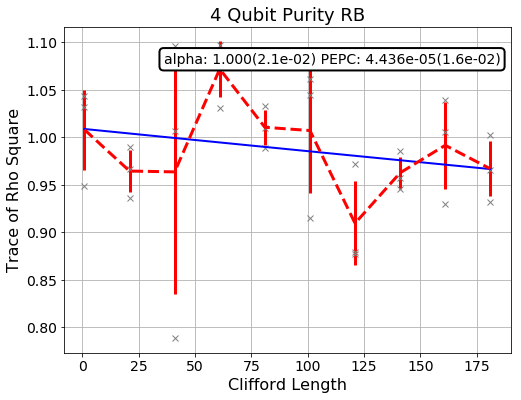

In [19]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rbfit_purity.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit Purity RB'%(nQ), fontsize=18)

plt.show()

## Standard RB results

For comparison, we also print the standard RB fit results

In [20]:
standard_result_list = []
count = 0
for rb_seed in range(len(rb_purity_circs)):
    for d in range(npurity):
        if d==0:
            standard_result_list.append(coherent_purity_result_list[count])
        count += 1

In [21]:
rbfit_standard = rb.RBFitter(standard_result_list, xdata, rb_opts['rb_pattern'])

In [22]:
print (rbfit_standard.fit)

[{'params': array([0.95113524, 0.9890997 , 0.01756276]), 'params_err': array([0.25826999, 0.00549458, 0.26303743]), 'epc': 0.008175221790507808, 'epc_err': 0.004166350907685159}, {'params': array([ 2.        ,  0.99661181, -1.03575205]), 'params_err': array([1.35398025, 0.00315084, 1.35692594]), 'epc': 0.0025411457608293664, 'epc_err': 0.002371164558629498}]


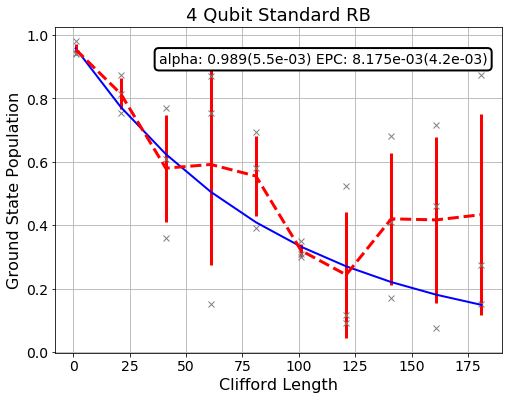

In [23]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rbfit_standard.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit Standard RB'%(nQ), fontsize=18)

plt.show()